In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import random

from tqdm.notebook import tqdm

sys.path.append("..")

from helper import load_reader
from visualize_ta import plot_preds, get_ndvi, get_nir

In [4]:
kwargs = dict(
    include_bands=True,
    include_cloud=False,
    include_ndvi=False,
    include_rvi=False,
    image_size=32,
    spatial_backbone="mean_pixel",
    min_area_to_ignore=1000,
    train_or_test="test"
)

## Load and visualize planet daily data

In [5]:
label_names, reader = load_reader(satellite="planet_daily", pos="34S_20E_259N", **kwargs)
image_stacks = [reader[i][0].numpy() for i in range(20)]

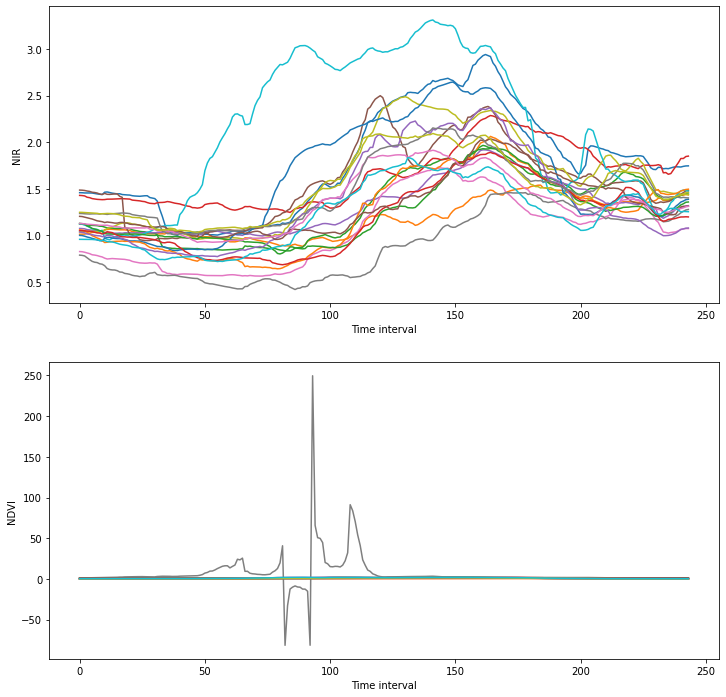

In [6]:
fig, ax = plt.subplots(2, figsize=(12, 12))
for img in image_stacks:
    ax[0].plot(img[:, 3])
    ax[1].plot(get_ndvi(img))
ax[0].set_ylabel("NIR")
ax[0].set_xlabel('Time interval')
ax[1].set_ylabel("NDVI")
ax[1].set_xlabel('Time interval');

## Load and visualize sentinel-2 data

In [7]:
label_names, reader = load_reader(satellite="sentinel_2", pos="34S_20E_259N", **kwargs)
image_stacks = [reader[i][0].numpy() for i in range(20)]

INFO: Ignoring 10/2417 fields with area < 1000m2


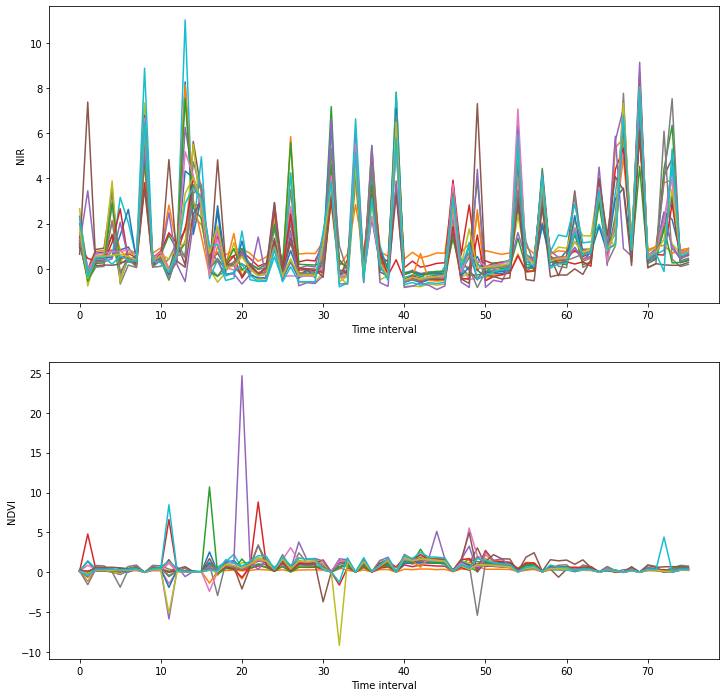

In [8]:
fig, ax = plt.subplots(2, figsize=(12, 12))
for img in image_stacks:
    ax[0].plot(img[:, 3])
    ax[1].plot(get_ndvi(img))
ax[0].set_ylabel("NIR")
ax[0].set_xlabel('Time interval')
ax[1].set_ylabel("NDVI")
ax[1].set_xlabel('Time interval');

## Load temporal augmentation model

In [9]:
from src.temporal_augmentor import TemporalAugmentor

In [10]:
def load_model(ta_model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    saved = torch.load(ta_model_path)
    config = saved["config"]
    temporal_augmentation_model = TemporalAugmentor(
        num_bands=config["input_dim"],
        hidden_size=config["lstm_hidden_size"],
        dropout=config["lstm_dropout"],
        input_timesteps=config["input_timesteps"],
        output_timesteps=config["output_timesteps"],
        gp_inference_indexes=[10],
        device=device,
    )
    temporal_augmentation_model.load_state_dict(saved["model_state"])
    temporal_augmentation_model.eval()
    return temporal_augmentation_model

In [11]:
label_names, reader = load_reader(satellite="planet_daily", pos="34S_20E_259N", **kwargs)

In [13]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.stack([reader[i][0] for i in range(2)]).to(DEVICE)

In [19]:
full_model = load_model("../temporal_augment_model_dump/qj6yeegb/100.pth")
temporal_dropout_model = load_model("../temporal_augment_model_dump/23zocyas/100.pth")

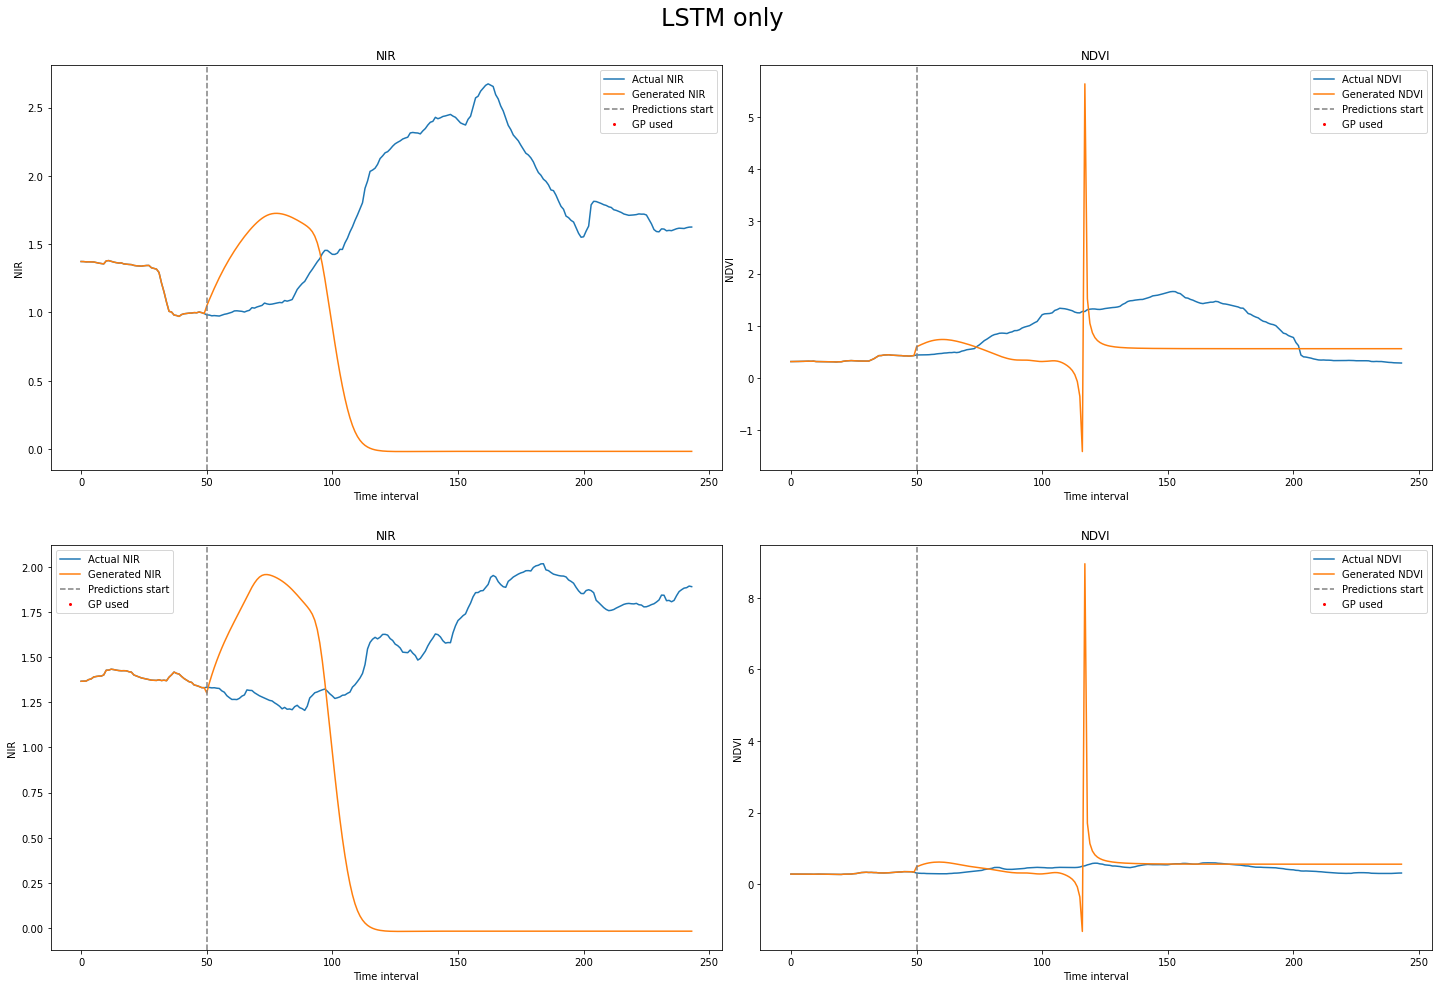

In [20]:
fig = plot_preds(
    model=temporal_dropout_model,
    x=x,
    title="LSTM only",
    gp_indexes=[],
    return_wandb_image=False
)

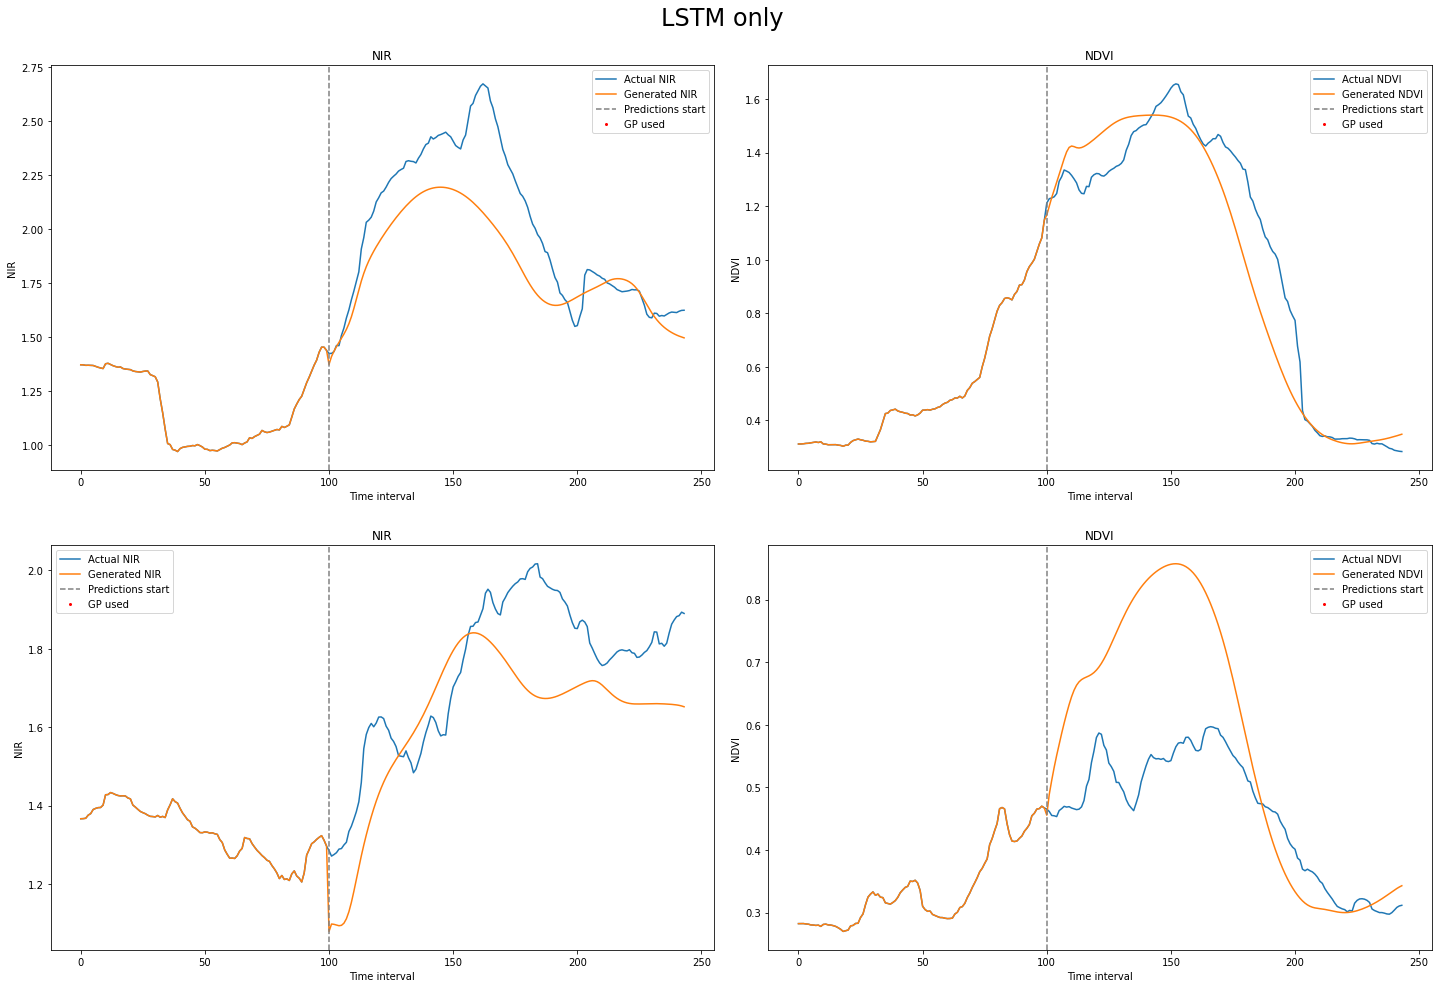

In [15]:
fig = plot_preds(
    model=full_model,
    x=x,
    title="LSTM only",
    gp_indexes=[],
    return_wandb_image=False
)

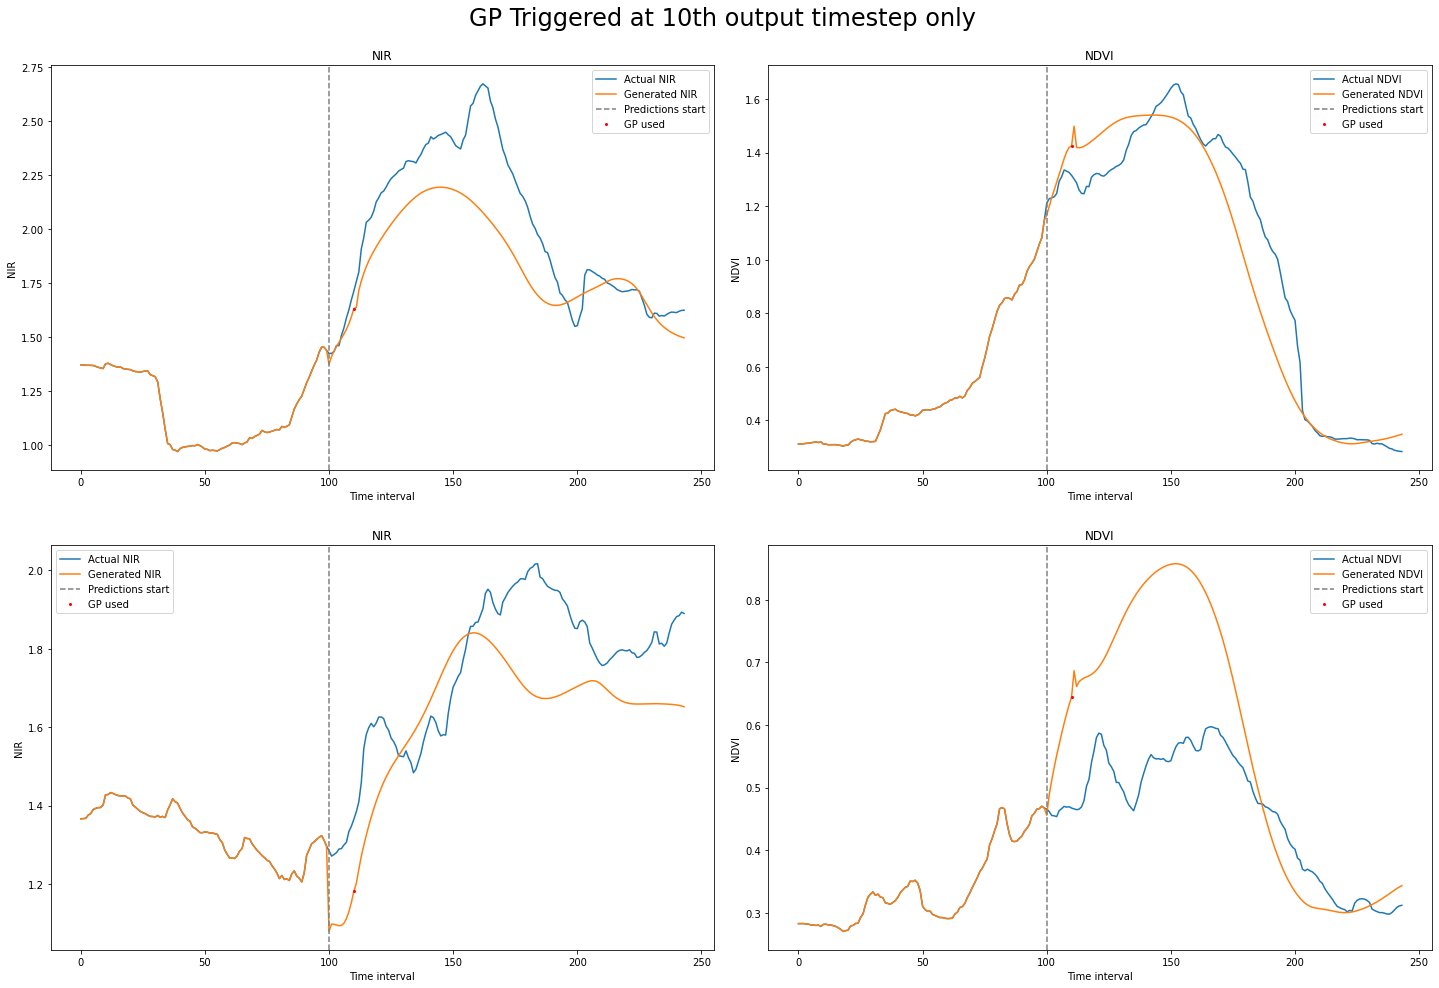

In [21]:
fig = plot_preds(
    model=full_model,
    x=x,
    title="GP Triggered at 10th output timestep only",
    gp_indexes=[10],
    return_wandb_image=False
)

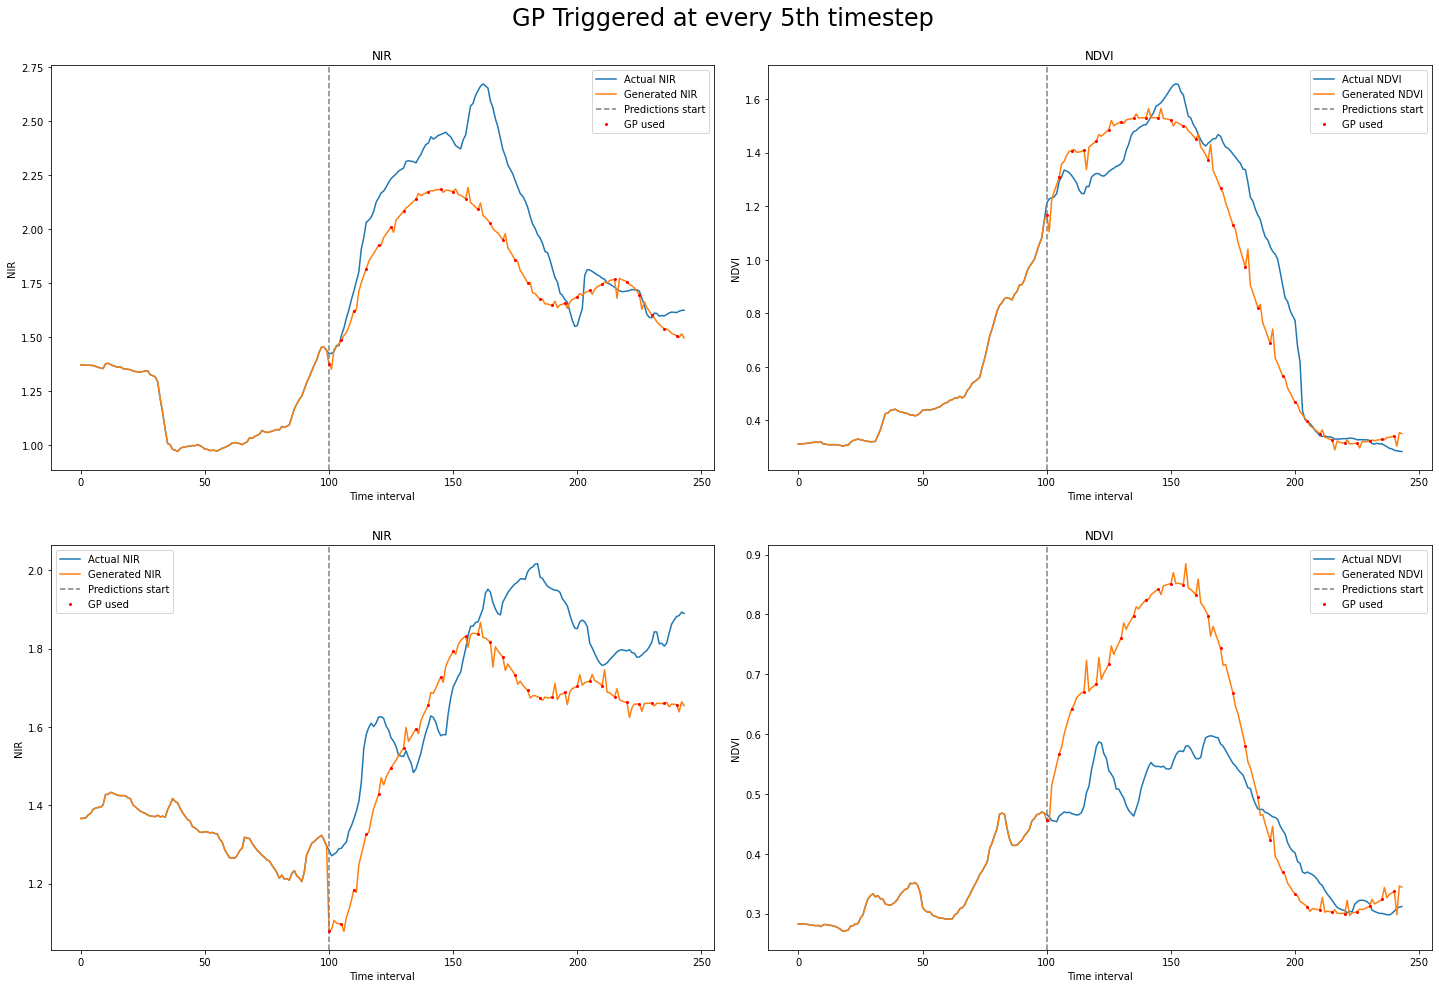

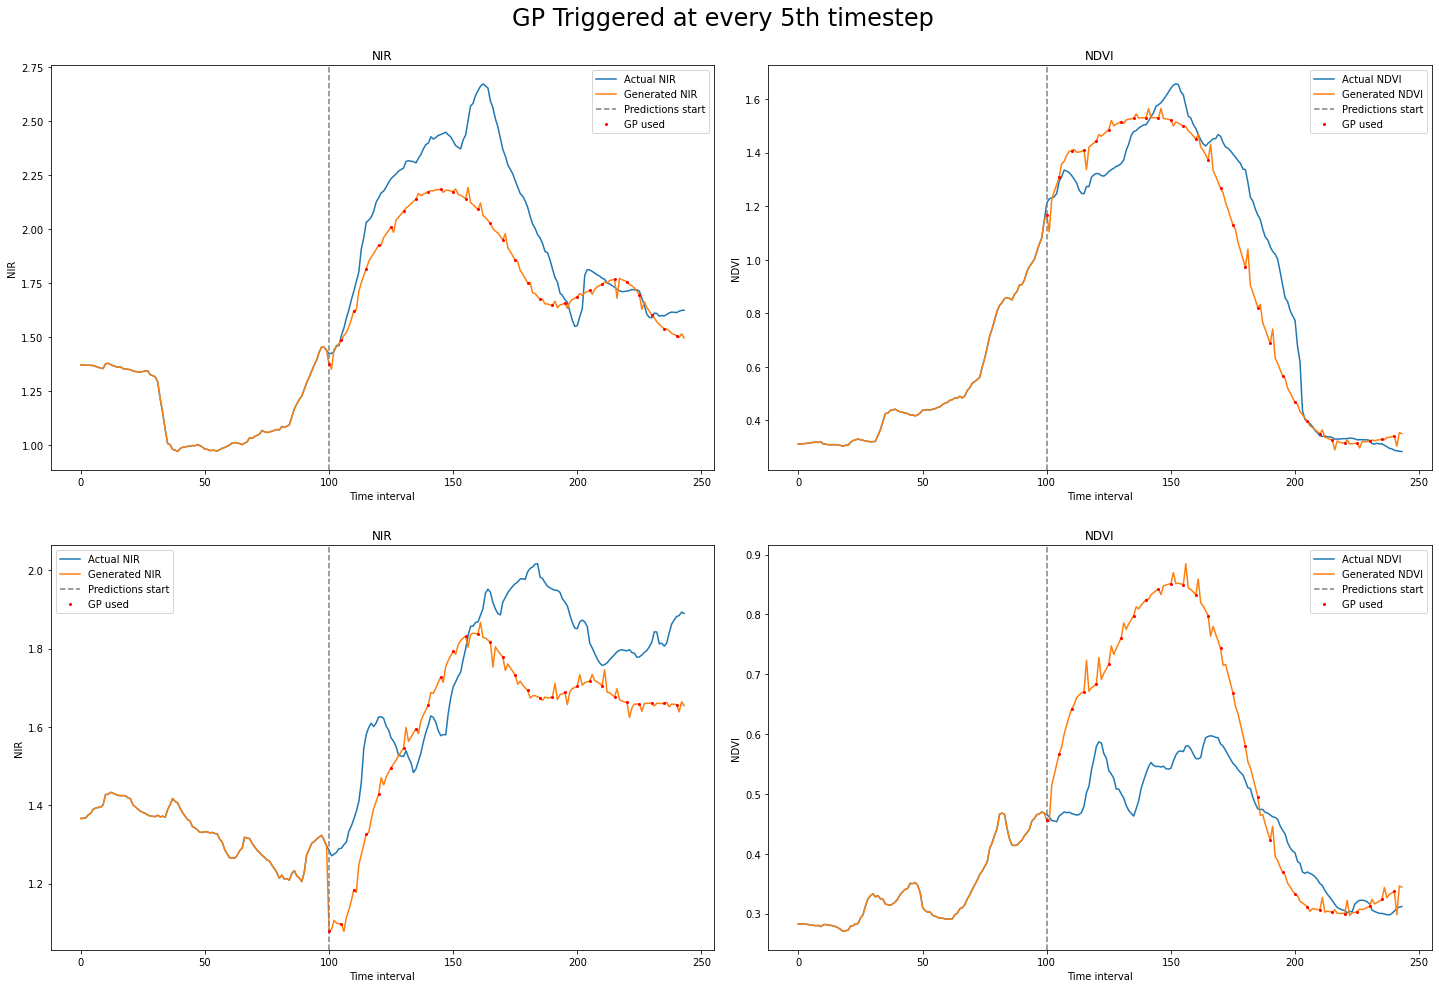

In [17]:
plot_preds(
    model=full_model,
    x=x,
    title="GP Triggered at every 5th timestep",
    gp_indexes=list(range(0, 144, 5)),
    return_wandb_image=False
)

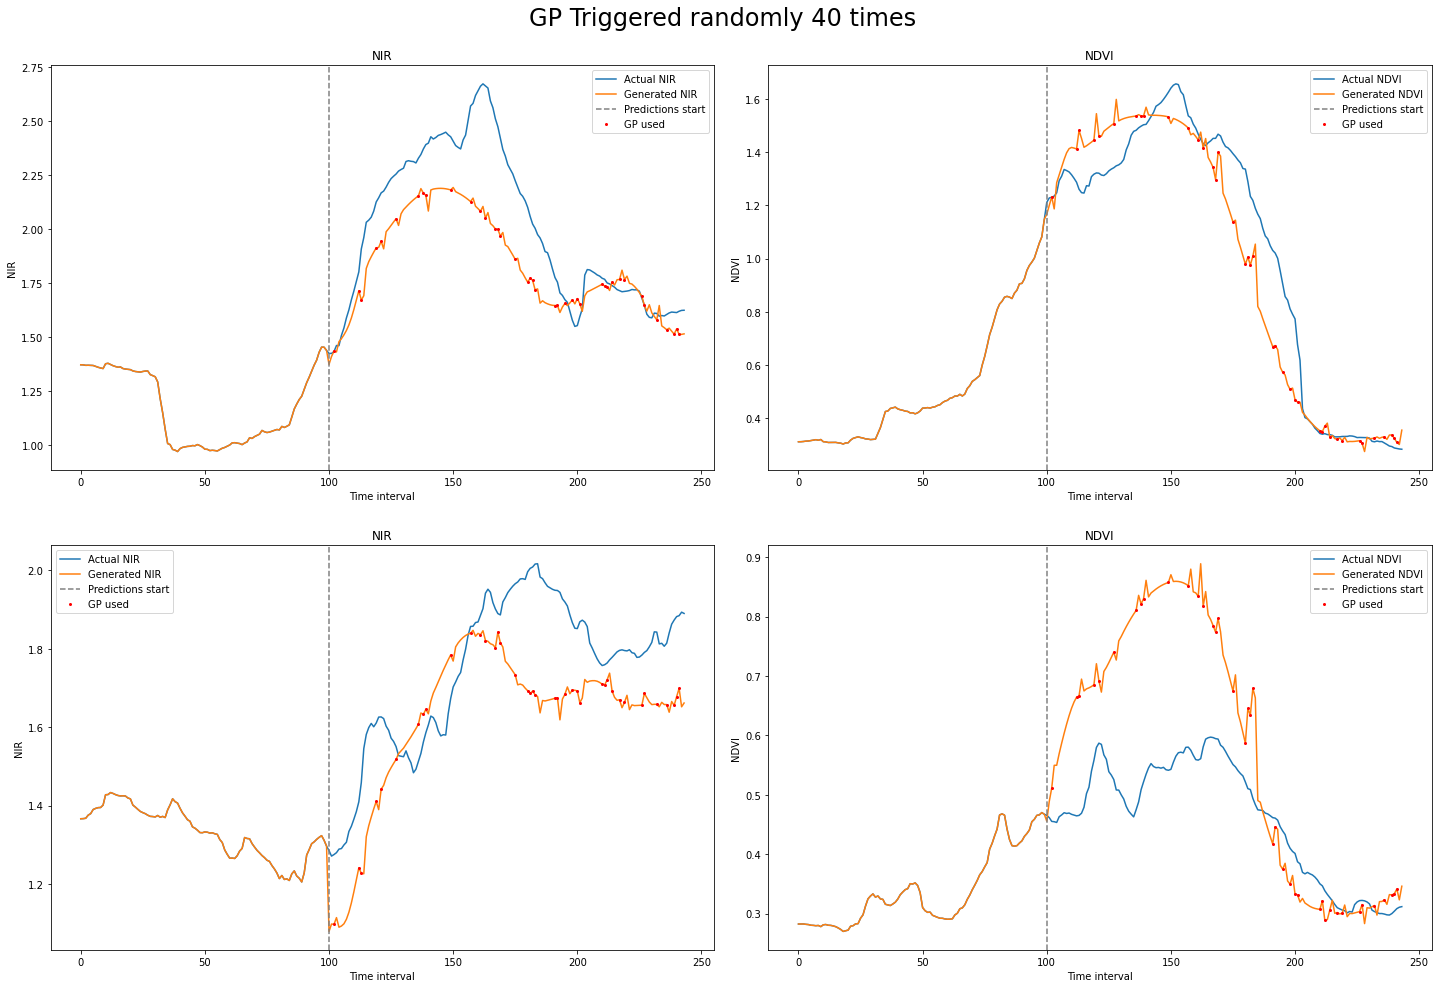

In [18]:
fig = plot_preds(
    model=full_model,
    x=x,
    title="GP Triggered randomly 40 times",
    gp_indexes=random.sample(range(0, 144), 40),
    return_wandb_image=False
)